In [1]:
import tensorflow as tf
import numpy as np
from cgan import C_GAN, ResNet9Generator
import matplotlib.pyplot as plt
from numpy import newaxis

print(tf.test.is_gpu_available)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from IPython import display
from ForSim import ForSim
import copy
import time

gan = C_GAN(generator=ResNet9Generator(noise=True))

# load the reference and initial channel models
ch_ref = np.load('./data/ch_ref.npy')

if os.path.exists('./data/cgan_mcmc.npy'):
    cgan_mcmc = np.load('./data/cgan_mcmc.npy')

else:
    cgan_mcmc = np.load('./data/ch_int.npy')
    cgan_mcmc = cgan_mcmc[newaxis,:,:]

# load log likelihood if there is one    
logL = np.empty((0,1))
if os.path.exists('./data/cgan_logL.npy'):
    logL = np.load('./data/cgan_logL.npy')
    logL = np.reshape(logL,[-1,1])
                    
[nz,ncmp] = ch_ref.shape

nt = 171
ntheta = 11
noise = 1
SNR = 30

Seis = np.load('./data/Seis_obs.npy') 

d_std = 0.55

<function is_gpu_available at 0x135c664d0>


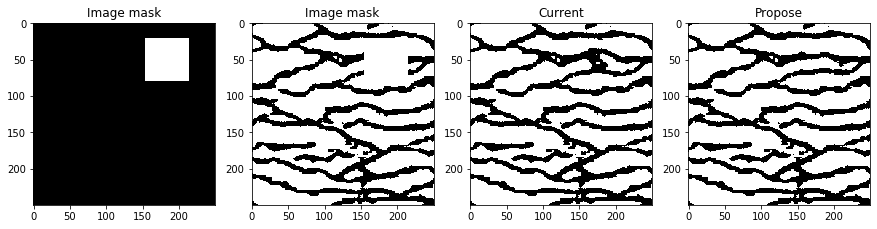

Iteration #41; logL_current is -7241.02; logL_propose is -7241.02; window size is 60.0
Iteration #42; logL_current is -7235.45; logL_propose is -7235.45; window size is 60.0
Iteration #43; logL_current is -7235.45; logL_propose is -7463.72; window size is 60.0
Iteration #44; logL_current is -7235.45; logL_propose is -7249.32; window size is 60.0
Iteration #45; logL_current is -7235.45; logL_propose is -7296.84; window size is 60.0
Iteration #46; logL_current is -7235.45; logL_propose is -7245.44; window size is 60.0
Iteration #47; logL_current is -7235.45; logL_propose is -7561.94; window size is 60.0
Iteration #48; logL_current is -7189.57; logL_propose is -7189.57; window size is 60.0


In [ ]:
gan = C_GAN(generator=ResNet9Generator(noise=True))

gan.restore_from_checkpoint()

# extended metropolis

grid_size = np.array([nz, ncmp, 1])

Seis_sim, _ = ForSim(cgan_mcmc[-1], nt, ntheta, 0, SNR)

logL_current = -0.5 * np.sum(np.square(Seis - Seis_sim)/np.square(d_std))

logL_propose = 0

ch_current = np.where(cgan_mcmc[-1] == 0, 1, -1)

nite = 50000

interval = 1

lim = np.array([30,30])

display_step = nite/5000

logL_step = 100

model_step = 1000

for i in range(nite):
        
    print("Iteration #{};".format(i+1),"logL_current is {:.2f};".format(logL_current),"logL_propose is {:.2f};".format(logL_propose),\
         "window size is {:.1f}".format(lim[0]*2))
    
    pos = np.zeros((2,))
    
    [xx,yy,zz] = np.meshgrid(np.arange(grid_size[1]),np.arange(grid_size[0]),np.arange(grid_size[2]))
    pos[0] = 0 + np.random.rand(1) * grid_size[1]
    pos[1] = 0 + np.random.rand(1) * grid_size[0]
    
    if (i + 1) >= interval * (200):

        lim = lim - 0.5

        interval = interval + 1

    if (i + 1) >= 8001:

        lim = np.array([10,10])
            
    rows, cols, _ = zip(*np.argwhere((np.abs(xx-pos[0])<lim[0]) & (np.abs(yy-pos[1])<lim[1])))
    
    input_image = np.copy(ch_current)
    input_image[rows, cols] = 1
    
    img = tf.convert_to_tensor(input_image[newaxis,:,:,newaxis], dtype=tf.float32)
    
    ch_propose = np.squeeze(np.array(gan.generate_image(img))) 
    
    n_rows, n_cols, _ = zip(*np.argwhere((np.abs(xx-pos[0])>=lim[0]) | (np.abs(yy-pos[1])>=lim[1])))
    
    ch_propose[n_rows, n_cols] = input_image[n_rows, n_cols]
    
    ch_propose = np.where(ch_propose < 0, -1, 1)
    
    ch_propose = (1 - ch_propose) / 2
    
    if np.mod(i+1,display_step) == 0:
        plt.figure(num = 1, figsize = (15,10))
        plt.subplot(1,4,1)
        plt.title('Image mask')
        temp = np.zeros((grid_size[0],grid_size[1])) - 1
        temp[rows, cols] = 1
        plt.imshow(temp,'gray')
        
        plt.subplot(1,4,2)
        plt.title('Image mask')
        plt.imshow(input_image,'gray')
        
        plt.subplot(1,4,3)
        plt.title('Current')
        plt.imshow(ch_current,'gray')
        
        plt.subplot(1,4,4)
        plt.title('Propose')
        plt.imshow(np.where(ch_propose == 0, 1, -1),'gray')
        
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(0.1) 

    Seis_sim, _ = ForSim(ch_propose, nt, ntheta, 0, SNR)
    
    logL_propose = -0.5 * np.sum(np.square(Seis - Seis_sim)/np.square(d_std))
    
    Pacc = np.exp(logL_propose - logL_current)
    
    u = np.random.rand(1)
    
    if u <= np.minimum(Pacc, 1):
        logL_current = logL_propose
        ch_current = np.where(ch_propose == 0, 1, -1)
        
    if np.mod(i+1,logL_step) == 0:
        logL = np.vstack((logL, [logL_current]))
        
    if np.mod(i+1,model_step) == 0:  
        cgan_mcmc = np.vstack((cgan_mcmc, (1 - ch_current[newaxis,:,:]) / 2))
        
np.save('cgan_mcmc.npy',np.array(cgan_mcmc))
np.save('cgan_logL.npy',np.array(logL))   